### Ultraytics Yolo v3 설치

In [1]:
!git clone https://github.com/ultralytics/yolov3
!cd yolov3;pip install -qr requirements.txt

Cloning into 'yolov3'...
remote: Enumerating objects: 10848, done.
remote: Counting objects: 100% (770/770), done.
remote: Compressing objects: 100% (407/407), done.
remote: Total 10848 (delta 504), reused 575 (delta 362), pack-reused 10078
Receiving objects: 100% (10848/10848), 9.87 MiB | 18.27 MiB/s, done.
Resolving deltas: 100% (7303/7303), done.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-api 1.18.0 requires importlib-metadata~=6.0.0, but you have importlib-metadata 6.7.0 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.1 which is incompatible.


In [2]:
import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.0.0 (Tesla P100-PCIE-16GB)


### Mushroom Dataset 다운로드
* Bounding Box를 그려본 결과, annotation에 mushroom fruiting body 뿐만 아니라 배지도 포함하고 있음.
* 배지 annotation은 제외하여 dataset preprocessing

In [3]:
# Ultralytics Yolo directory
!mkdir /kaggle/working/dataset
!cd /kaggle/working/dataset; mkdir images; mkdir labels
!cd /kaggle/working/dataset/images; mkdir train; mkdir val
!cd /kaggle/working/dataset/labels; mkdir train; mkdir val

In [4]:
!cat /kaggle/input/mushroom-dataset/VL5_/생육/표고_생육실_12_15658210.json

{
	"INFO": {
		"DATASET_NAME": "표고 버섯(생육)",
		"DATASET_DETAIL": "(스마트팜 통합데이터_버섯)",
		"VERSION": "1.0",
		"LICENSE": "",
		"CREATE_DATE_TIME": "2021-12-20 17:08:32",
		"CONTRIBUTOR": "",
		"URL": "https://www.labelon.kr",
		"CATEGORY_NAME": "표고"
	},
	"IMAGE": {
		"IMAGE_URL": "https://images.labelon.kr/2021/11/23/e78a8b0ec38d456db0c874aa13befd9e.jpg",
		"IMAGE_FILE_NAME": "표고_생육실_12_15658210.jpg",
		"WIDTH": 1080,
		"HEIGHT": 1920,
		"ANNOTATION_COUNT": 3
	},
	"ANNOTATION_INFO": [
		{
			"ID": 73725617,
			"BOUNDING_BOX_X_COORDINATE": 271,
			"BOUNDING_BOX_Y_COORDINATE": 834,
			"BOUNDING_BOX_WIDTH": 632,
			"BOUNDING_BOX_HEIGHT": 394,
			"SEGMENTATION": null,
			"SEGMENTATION_AREA_TOTAL": null,
			"CROWDSOURSING_OPERATION_ALTERNATIVE": true
		},
		{
			"ID": 73725618,
			"BOUNDING_BOX_X_COORDINATE": 508,
			"BOUNDING_BOX_Y_COORDINATE": 939,
			"BOUNDING_BOX_WIDTH": 105,
			"BOUNDING_BOX_HEIGHT": 91,
			"SEGMENTATION": null,
			"SEGMENTATION_AREA_TOTAL": null,
			"CROWDSOURSING_OPERATIO

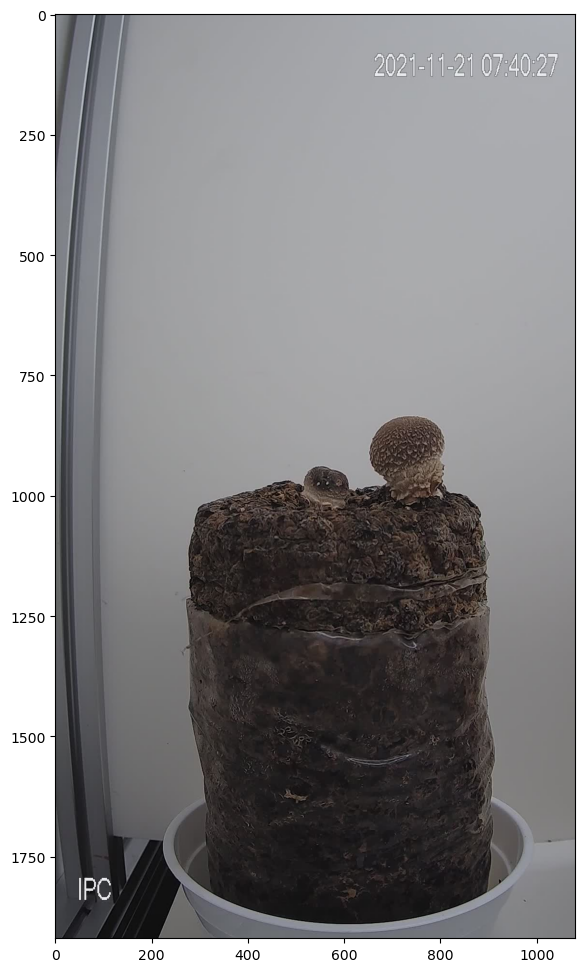

In [11]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.cvtColor(cv2.imread('/kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_12_15658210.jpg'), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.imshow(img)

In [19]:
import json

def extract_bbox_info(input_json_file):
    # Load json file
    with open(input_json_file) as file:
      load_json_file = json.load(file)
    
    x = []
    y = []
    w = []
    h = []

    anno_info = load_json_file['ANNOTATION_INFO']
    for obj in anno_info:
        x.append(obj['BOUNDING_BOX_X_COORDINATE'])
        y.append(obj['BOUNDING_BOX_Y_COORDINATE'])
        w.append(obj['BOUNDING_BOX_WIDTH'])
        h.append(obj['BOUNDING_BOX_HEIGHT'])

    return x, y, w, h


In [25]:
def draw_bbox(img_file, x, y, w, h):
    img = cv2.imread(img_file) 
    draw_img = img.copy()

    for i in range(len(x)):
        x_i = x[i]
        y_i = y[i]
        w_i = w[i]
        h_i = h[i]
        # 좌상단 좌표
        top_left = (x_i,y_i)
        # 우하단 좌표
        bottom_right = (x_i + w_i, y_i + h_i)
        caption = 'obj {0}'.format(i)
        cv2.rectangle(draw_img, top_left, bottom_right, color=(0, 255, 0), thickness=2)
        cv2.putText(draw_img, caption, (x_i, y_i - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2)

    draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,12))
    plt.imshow(draw_img)

x=[271, 508, 650], y=[834, 939, 835], w=[632, 105, 162], h=[394, 91, 186]


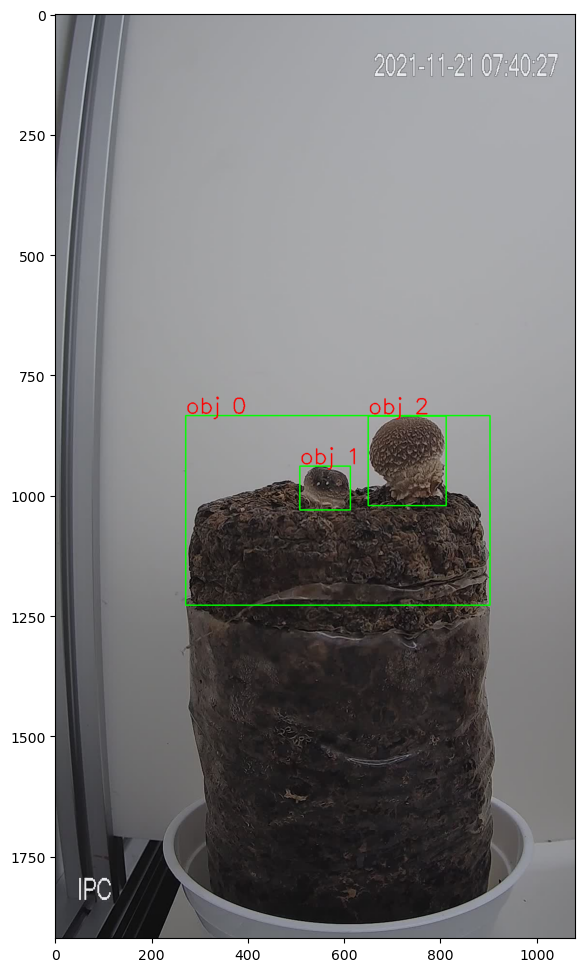

In [26]:
# 예시1
json_filepath = '/kaggle/input/mushroom-dataset/VL5_/생육/표고_생육실_12_15658210.json'
img_filepath = '/kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_12_15658210.jpg'

x, y, w, h = extract_bbox_info(json_filepath)
print('x={0}, y={1}, w={2}, h={3}'.format(x, y, w, h))

draw_bbox(img_filepath, x, y, w, h)

x=[177, 473], y=[148, 148], w=[688, 201], h=[727, 206]


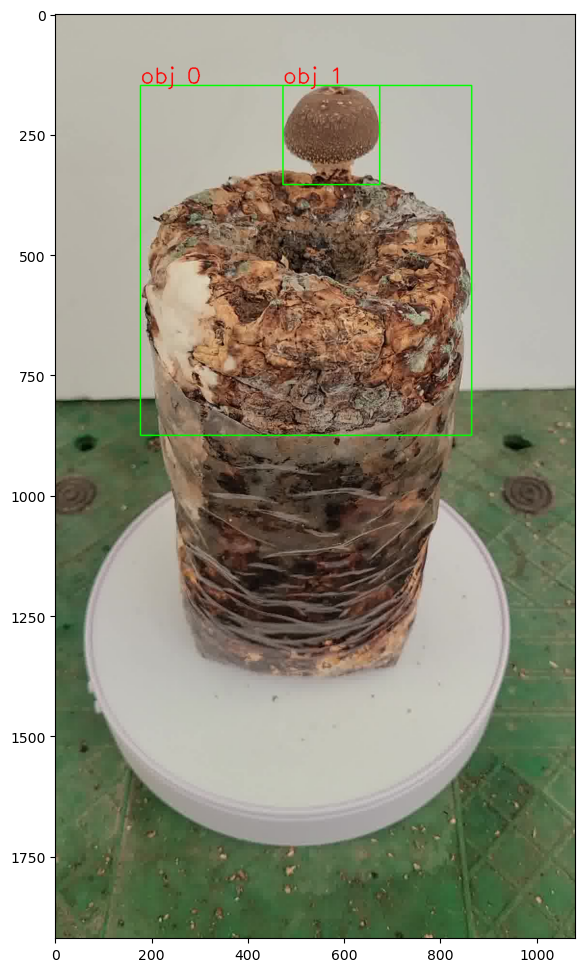

In [29]:
# 예시2
json_filepath = '/kaggle/input/mushroom-dataset/VL5_/생육/표고_생육실_10_15645495.json'
img_filepath = '/kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_10_15645495.jpg'

x, y, w, h = extract_bbox_info(json_filepath)
print('x={0}, y={1}, w={2}, h={3}'.format(x, y, w, h))

draw_bbox(img_filepath, x, y, w, h)

x=[333], y=[986], w=[631], h=[227]


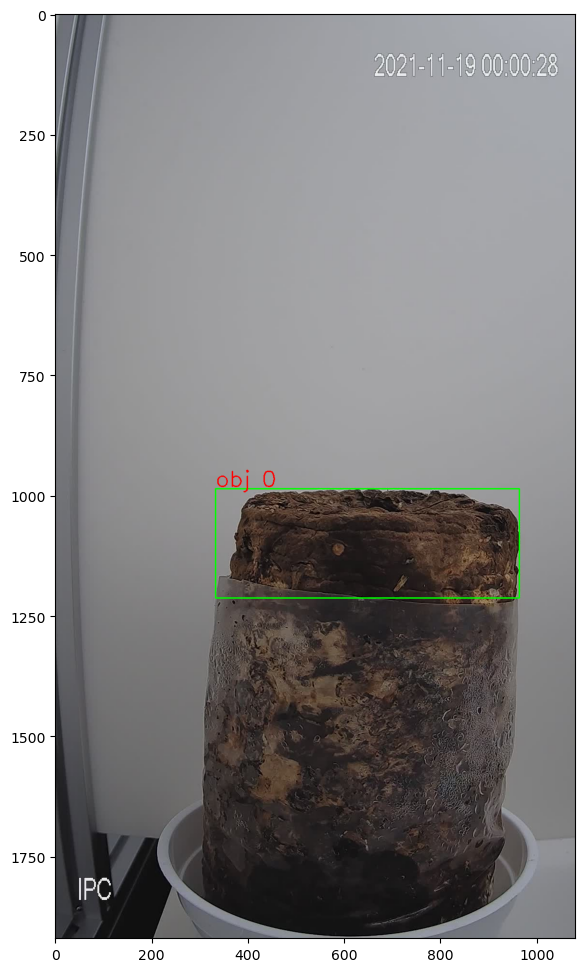

In [28]:
# 예시3
json_filepath = '/kaggle/input/mushroom-dataset/VL5_/생육/표고_생육실_10_15639486.json'
img_filepath = '/kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_10_15639486.jpg'

x, y, w, h = extract_bbox_info(json_filepath)
print('x={0}, y={1}, w={2}, h={3}'.format(x, y, w, h))

draw_bbox(img_filepath, x, y, w, h)

### Oxford Pet 데이터 세트의 annotation을 Ultralytics Yolo format으로 생성

In [30]:
CLASS_NAMES = ['표고']

In [31]:
# 1개의 annotation json 파일을 Yolo 포맷용 txt 파일로 변경하는 함수
def json_to_txt(input_json_file, output_txt_file, object_name):
  # Load json file
  with open(input_json_file) as json_file:
    anno_data = json.load(json_file)

  # Width and height of input image
  img_data = anno_data['IMAGE']
  img_width = img_data['WIDTH']
  img_height = img_data['HEIGHT']
    
  # object 수가 2개 이상인 annotation json 파일으로 제한함  
  if img_data['ANNOTATION_COUNT'] <= 1:
    return None

  value_str = None
  # json 파일 내에 있는 모든 object에 대해서
  with open(output_txt_file, 'w') as output_fpointer:
    for index, obj in enumerate(anno_data['ANNOTATION_INFO']):
      # json 파일 내 'ANNOTATION_INFO'에서 첫번째 object(배지)는 제외  
      if index == 0:
        continue
        
      # Bounding box coordinate (x, y), width, height
      x = obj['BOUNDING_BOX_X_COORDINATE']
      y = obj['BOUNDING_BOX_Y_COORDINATE']
      w = obj['BOUNDING_BOX_WIDTH']
      h = obj['BOUNDING_BOX_HEIGHT']

      # Yolo annotation 포맷으로 변환
      class_id, cx_norm, cy_norm, w_norm, h_norm = convert_yolo_coord(object_name, img_width, img_height, x, y, w, h)
      value_str = ('{0} {1} {2} {3} {4}').format(class_id, cx_norm, cy_norm, w_norm, h_norm)
      output_fpointer.write(value_str+'\n')


In [32]:
# object_name과 원본 좌표를 입력하여 Yolo 포맷으로 변환
def convert_yolo_coord(object_name, img_width, img_height, x, y, w, h):
  class_id = CLASS_NAMES.index(object_name)
  center_x_norm = (x + w/2) / img_width
  center_y_norm = (y + h/2) / img_height
  width_norm = w / img_height
  height_norm = h / img_height

  return class_id, round(center_x_norm, 7), round(center_y_norm, 7), round(width_norm, 7), round(height_norm, 7)

In [37]:
import os
import numpy as np
import pandas as pd

# Train, valid 메타데이터 생
def make_train_val_df(root_img_dir, root_anno_dir):
  img_dir = os.path.join(root_img_dir, '생육/')
  anno_dir = os.path.join(root_anno_dir, '생육/')

  df = pd.DataFrame(data={'img_name': os.listdir(img_dir)})
  df['filename'] = df['img_name'].apply(lambda x:x[x.rfind('/')+1:x.rfind('.')])
  df['img_filepath'] = img_dir + df['filename'] + '.jpg'
  df['anno_filepath'] = anno_dir + df['filename'] + '.json'
  df['class_name'] = df['filename'].apply(lambda x:x[:x.find('_')])
  # annotation json 파일이 없는데, jpg 파일이 있는 경우가 있음. 이들의 경우 pet_df에서 해당 rows를 삭제함.
  df = remove_no_annos(df)
  
  anno_count = []  
  for index, row in df.iterrows():
    with open(row['anno_filepath']) as json_file:
      anno_data = json.load(json_file)
    img_data = anno_data['IMAGE']
    anno_count.append(img_data['ANNOTATION_COUNT'])
    
  df['anno_count'] = anno_count
  # 'ANNOTATION_COUNT'가 1개 이하는 제외
  df = df[df['anno_count'] > 1]

  return df

# annotation json 파일이 없는데, jpg 파일이 있는 경우에 이들을 dataframe에서 삭제하기 위한 함수.
def remove_no_annos(df):
  remove_rows = []
  for index, row in df.iterrows():
    anno_filepath = row['anno_filepath']
    if not os.path.exists(anno_filepath):
      print('##### index:', index, anno_filepath, '가 존재하지 않아서 Dataframe에서 삭제함')
      #해당 DataFrame index를 remove_rows list에 담음.
      remove_rows.append(index)
  # DataFrame의 index가 담긴 list를 drop()인자로 입력하여 해당 rows를 삭제
  df = df.drop(remove_rows, axis=0, inplace=False)
  return df

train_df = make_train_val_df('/kaggle/input/mushroom-dataset/TS5_', '/kaggle/input/mushroom-dataset/TL5_')
val_df = make_train_val_df('/kaggle/input/mushroom-dataset/VS5_', '/kaggle/input/mushroom-dataset/VL5_')


In [38]:
val_df.head(5)

,img_name,filename,img_filepath,anno_filepath,class_name,anno_count
0,표고_생육실_18_15657297.jpg,표고_생육실_18_15657297,/kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_...,/kaggle/input/mushroom-dataset/VL5_/생육/표고_생육실_...,표고,4
2,표고_생육실_13_15642308.jpg,표고_생육실_13_15642308,/kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_...,/kaggle/input/mushroom-dataset/VL5_/생육/표고_생육실_...,표고,2
3,표고_생육실_10_15646250.jpg,표고_생육실_10_15646250,/kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_...,/kaggle/input/mushroom-dataset/VL5_/생육/표고_생육실_...,표고,2
4,표고_생육실_7_15657891.jpg,표고_생육실_7_15657891,/kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_...,/kaggle/input/mushroom-dataset/VL5_/생육/표고_생육실_...,표고,2
5,표고_생육실_1_15649556.jpg,표고_생육실_1_15649556,/kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_...,/kaggle/input/mushroom-dataset/VL5_/생육/표고_생육실_...,표고,2


In [39]:
print(train_df['img_filepath'][0])
print(train_df['anno_filepath'][0])

/kaggle/input/mushroom-dataset/TS5_/생육/표고_생육실_11_10199270.jpg
/kaggle/input/mushroom-dataset/TL5_/생육/표고_생육실_11_10199270.json


In [40]:
print(train_df.shape)
print(val_df.shape)

(15155, 6)
(3051, 6)


In [41]:
# 데이터 크기를 축소하여 학습
train_tiny_df = train_df.sample(n=3200, random_state=1004) # train 3200
val_tiny_df = val_df.sample(n=800, random_state=1004) # valid 800

In [42]:
print(train_tiny_df.shape)
print(val_tiny_df.shape)

(3200, 6)
(800, 6)


### VOC Format의 여러개 json 파일들을 Yolo format으로 변환 후 Ultralytics directory 구조로 입력

In [43]:
import shutil

def make_yolo_anno_file(df, tgt_images_dir, tgt_labels_dir):
  for index, row in df.iterrows():
    src_image_path = row['img_filepath']
    src_label_path = row['anno_filepath']
    object_name = row['class_name']
    # image의 경우 target images 디렉토리로 단순 copy
    shutil.copy(src_image_path, tgt_images_dir)
    # yolo format으로 annotation할 txt 파일의 절대 경로명을 지정
    target_label_path = tgt_labels_dir + row['filename'] + '.txt'
    # annotation의 경우 xml 파일을 target labels 디렉토리에 Ultralytics Yolo format으로 변환하여  만듬
    json_to_txt(src_label_path, target_label_path, object_name)

# train용 images와 labels annotation 생성.
make_yolo_anno_file(train_tiny_df, '/kaggle/working/dataset/images/train/', '/kaggle/working/dataset/labels/train/')
# val용 images와 labels annotation 생성
make_yolo_anno_file(val_tiny_df, '/kaggle/working/dataset/images/val/', '/kaggle/working/dataset/labels/val/')

In [44]:
!ls /kaggle/working/dataset/images/train/

표고_생육실_10_10146763.jpg  표고_생육실_19_10702709.jpg
표고_생육실_10_10146767.jpg  표고_생육실_19_10702713.jpg
표고_생육실_10_10146778.jpg  표고_생육실_19_10702716.jpg
표고_생육실_10_10146784.jpg  표고_생육실_19_10703976.jpg
표고_생육실_10_10146796.jpg  표고_생육실_19_10703986.jpg
표고_생육실_10_10146805.jpg  표고_생육실_19_10703988.jpg
표고_생육실_10_10189726.jpg  표고_생육실_19_10704002.jpg
표고_생육실_10_10189732.jpg  표고_생육실_19_10704008.jpg
표고_생육실_10_10189734.jpg  표고_생육실_19_10704013.jpg
표고_생육실_10_10189735.jpg  표고_생육실_19_10704016.jpg
표고_생육실_10_10189736.jpg  표고_생육실_19_10704021.jpg
표고_생육실_10_10189738.jpg  표고_생육실_19_10704026.jpg
표고_생육실_10_10189739.jpg  표고_생육실_19_10704028.jpg
표고_생육실_10_10189740.jpg  표고_생육실_19_10704029.jpg
표고_생육실_10_10189743.jpg  표고_생육실_19_10704034.jpg
표고_생육실_10_10189744.jpg  표고_생육실_19_10704036.jpg
표고_생육실_10_10189745.jpg  표고_생육실_19_10704045.jpg
표고_생육실_10_10189749.jpg  표고_생육실_19_10704047.jpg
표고_생육실_10_10189753.jpg  표고_생육실_19_10705328.jpg
표고_생육실_10_10189765.jpg  표고_생육실_19_10705333.jpg
표고_생육실_10_10189767.jpg  표고_생육실_19_10705334.jpg
표고_생육실_10_101

In [45]:
!ls /kaggle/working/dataset/labels/train/

표고_생육실_10_10146763.txt  표고_생육실_19_10702709.txt
표고_생육실_10_10146767.txt  표고_생육실_19_10702713.txt
표고_생육실_10_10146778.txt  표고_생육실_19_10702716.txt
표고_생육실_10_10146784.txt  표고_생육실_19_10703976.txt
표고_생육실_10_10146796.txt  표고_생육실_19_10703986.txt
표고_생육실_10_10146805.txt  표고_생육실_19_10703988.txt
표고_생육실_10_10189726.txt  표고_생육실_19_10704002.txt
표고_생육실_10_10189732.txt  표고_생육실_19_10704008.txt
표고_생육실_10_10189734.txt  표고_생육실_19_10704013.txt
표고_생육실_10_10189735.txt  표고_생육실_19_10704016.txt
표고_생육실_10_10189736.txt  표고_생육실_19_10704021.txt
표고_생육실_10_10189738.txt  표고_생육실_19_10704026.txt
표고_생육실_10_10189739.txt  표고_생육실_19_10704028.txt
표고_생육실_10_10189740.txt  표고_생육실_19_10704029.txt
표고_생육실_10_10189743.txt  표고_생육실_19_10704034.txt
표고_생육실_10_10189744.txt  표고_생육실_19_10704036.txt
표고_생육실_10_10189745.txt  표고_생육실_19_10704045.txt
표고_생육실_10_10189749.txt  표고_생육실_19_10704047.txt
표고_생육실_10_10189753.txt  표고_생육실_19_10705328.txt
표고_생육실_10_10189765.txt  표고_생육실_19_10705333.txt
표고_생육실_10_10189767.txt  표고_생육실_19_10705334.txt
표고_생육실_10_101

### Mushroom Dataset 학습 수행

In [46]:
!wget -O /kaggle/working/dataset/mushroom_kaggle.yaml https://github.com/giyeongyoon/mushroom/raw/main/mushroom_kaggle.yaml

--2023-08-28 08:26:57--  https://github.com/giyeongyoon/mushroom/raw/main/mushroom_kaggle.yaml
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/giyeongyoon/mushroom/main/mushroom_kaggle.yaml [following]
--2023-08-28 08:26:57--  https://raw.githubusercontent.com/giyeongyoon/mushroom/main/mushroom_kaggle.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195 [text/plain]
Saving to: ‘/kaggle/working/dataset/mushroom_kaggle.yaml’

/kaggle/working/dat 100%[===================>]     195  --.-KB/s    in 0s      

2023-08-28 08:26:57 (8.24 MB/s) - ‘/kaggle/working/dataset/mushroom_kaggle.yaml’ save

In [47]:
!ls /kaggle/working/dataset

images	labels	mushroom_kaggle.yaml


In [ ]:
### train시 1시간 정도 소모 됩니다. colab환경에서 아래를 browser의 console 에서 붙여 넣기가 필요할 수 있습니다.
### shift+cntr+i 로 browser console 열기
# https://github.com/chulminkw/DLCV/blob/master/data/util/colab_autoclick.js
'''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''

In [48]:
# Google Drive 밑에 Directory 생성
!mkdir /kaggle/working/mush_workdir

In [52]:
!cd /kaggle/working/yolov3; python train.py --img 640 --batch 16 --epochs 20 --data /kaggle/working/dataset/mushroom_kaggle.yaml --weights yolov3.pt --project=/kaggle/working/mush_workdir \
                                     --name shiitake --exist-ok

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov3.pt, cfg=, data=/kaggle/working/dataset/mushroom_kaggle.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/kaggle/working/mush_workdir, name=shiitake, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest


### 학습된 모델 파일을 이용하여 Inference 수행

In [54]:
!cd /kaggle/working/yolov3; python detect.py --source /kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_10_15645500.jpg --weights /kaggle/working/mush_workdir/shiitake/weights/best.pt --conf 0.5 \
                            --project=/kaggle/working/data/output --name=run_image --exist-ok --line-thickness 2

detect: weights=['/kaggle/working/mush_workdir/shiitake/weights/best.pt'], source=/kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_10_15645500.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/kaggle/working/data/output, name=run_image, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv3 🚀 v9.6.0-106-g316c2e37 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 190 layers, 61497430 parameters, 0 gradients, 154.5 GFLOPs
image 1/1 /kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_10_15645500.jpg: 640x384 1 표고, 39.4ms
Speed: 0.5ms pre-process, 39.4ms inference, 1.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/data/output/run_image


In [55]:
!cd /kaggle/working/yolov3; python detect.py --source /kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_10_15645476.jpg --weights /kaggle/working/mush_workdir/shiitake/weights/best.pt --conf 0.5 \
                            --project=/kaggle/working/data/output --name=run_image --exist-ok --line-thickness 2

detect: weights=['/kaggle/working/mush_workdir/shiitake/weights/best.pt'], source=/kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_10_15645476.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/kaggle/working/data/output, name=run_image, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv3 🚀 v9.6.0-106-g316c2e37 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 190 layers, 61497430 parameters, 0 gradients, 154.5 GFLOPs
image 1/1 /kaggle/input/mushroom-dataset/VS5_/생육/표고_생육실_10_15645476.jpg: 640x384 1 표고, 36.4ms
Speed: 0.5ms pre-process, 36.4ms inference, 1.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/data/output/run_image


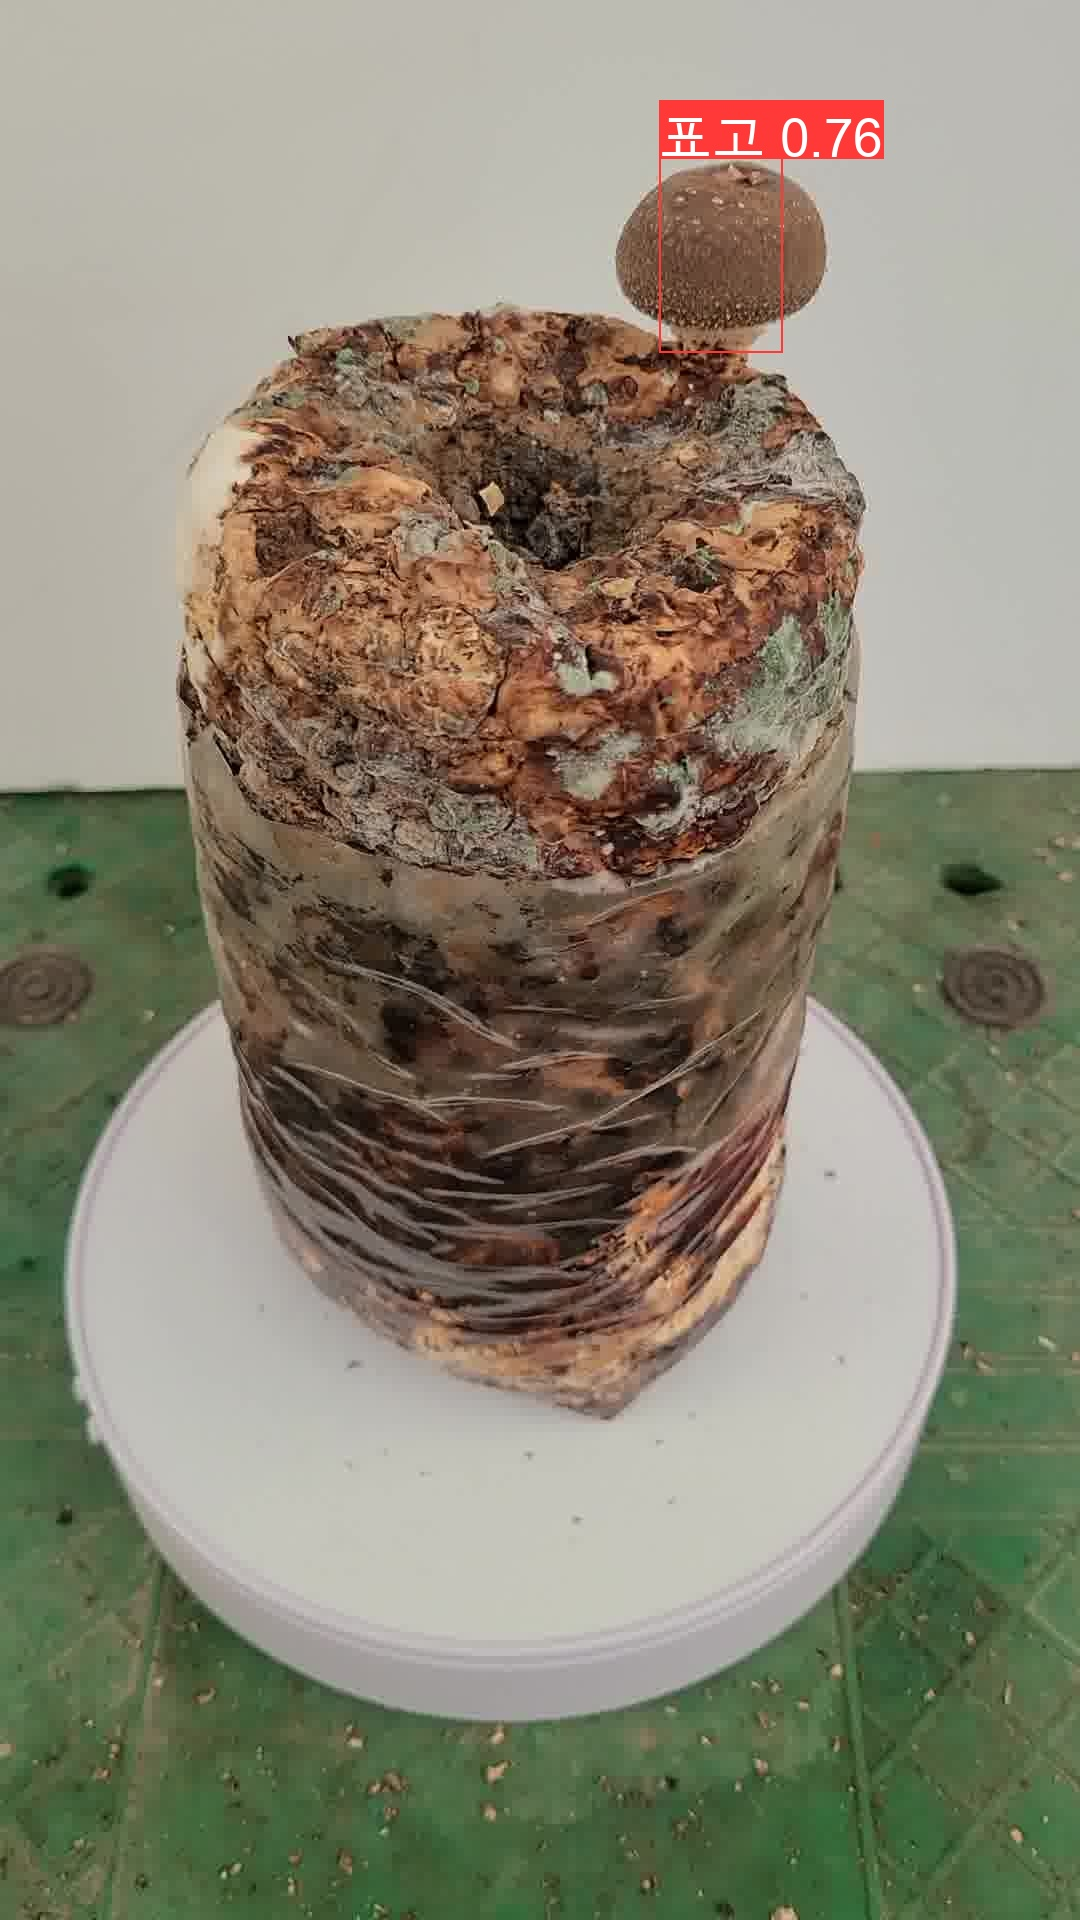

In [56]:
from IPython.display import Image

Image(data='/kaggle/working/data/output/run_image/표고_생육실_10_15645500.jpg', width=400)

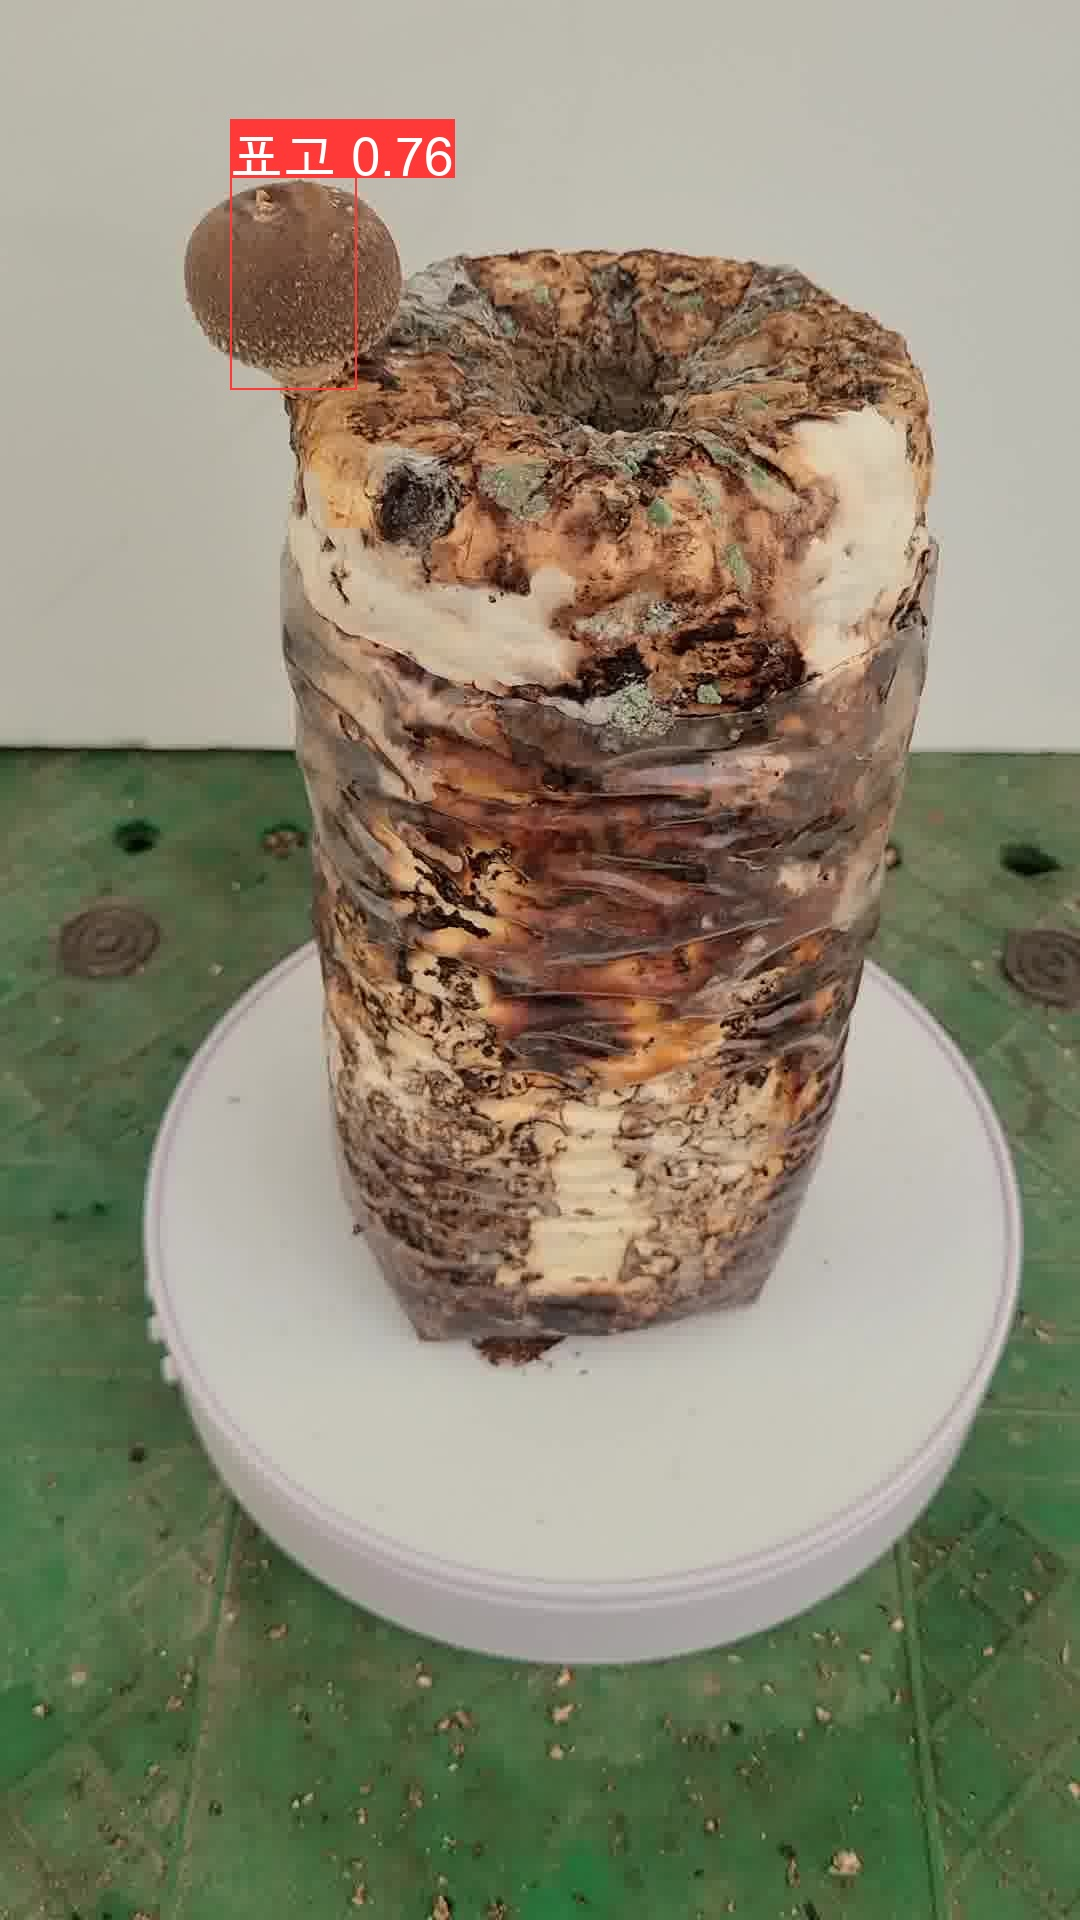

In [57]:
Image(data='/kaggle/working/data/output/run_image/표고_생육실_10_15645476.jpg', width=400)